# Data Cleaning

Here, we will clean the data that we scraped for the 2021 Boston Marathon.

## I. Import packages and data

Let's import the packages we will need and import the data to a pandas DataFrame. The data exists in a .csv file.

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import cleaningfuncs as cf

pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

boston = pd.read_csv('./data/boston.csv', skipinitialspace=True)

Let's take a first look at the data in its raw form, as well as some summary information about the DataFrame.

In [2]:
boston

,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
0,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
1,1,1,1,M,1,"Kipruto, Benson (KEN)",4,01:06:22,02:09:51,02:09:51
2,2,2,2,M,1,"Berhanu, Lemi (ETH)",3,01:06:23,02:10:37,02:10:37
3,3,3,3,M,1,"Yimer, Jemal (ETH)",21,01:06:21,02:10:38,02:10:38
4,4,4,4,M,1,"Ayana, Tsedat (ETH)",12,01:06:22,02:10:47,02:10:47
...,...,...,...,...,...,...,...,...,...,...
18121,NaN,NaN,NaN,W,12,"Rigney, Hansi (USA)",15935,NaN,NaN,NaN
18122,NaN,NaN,NaN,W,12,"Troisi, Cathleen (USA)",16100,NaN,NaN,NaN
18123,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
18124,Place Overall,Place Gender,Place Division,W,13,NaN,BIB,HALF,Finish Net,Finish Gun


In [3]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18126 entries, 0 to 18125
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   place_overall   15442 non-null  object
 1   place_gender    15436 non-null  object
 2   place_division  15436 non-null  object
 3   sex             18126 non-null  object
 4   age_group       18126 non-null  object
 5   name            18093 non-null  object
 6   bib             18125 non-null  object
 7   half_split      15612 non-null  object
 8   finish_net      15442 non-null  object
 9   finish_gun      15442 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


Immediately, we can see some issues with the data that will require cleaning, including but not limited to: 

* The scraper grabbed some header rows from the website as it crawled through the pages.
* The data includes runners of all ages, whereas we are only interested in looking at runners age 18-39.
* There are two different finish time columns, finish_net and finish_gun.
* The data type for every column is object.
* There are rows with missing data.
* The column names could be a bit cleaner and more descriptive.
* First name, last name, and country are all grouped under one column. They would be more useful in separate columns.
* There aren't any columns that directly tell us the pace strategy of each runner.

We will address all of these issues and more below.

## II. Remove Irrelevant Data and Fix Column Types

First, let's remove the header rows that the scraper grabbed. These are table headers on the webpages containing the results. We could subset these in various ways, but let's look for rows that have either "bib" or "BIB" in the bib column.

In [4]:
headers = boston[(boston['bib'] == 'BIB') | (boston['bib'] == 'bib')]
headers

,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
0,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
1001,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
2002,Place Overall,Place Gender,Place Division,M,1,NaN,BIB,HALF,Finish Net,Finish Gun
2570,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
2571,Place Overall,Place Gender,Place Division,M,2,NaN,BIB,HALF,Finish Net,Finish Gun
...,...,...,...,...,...,...,...,...,...,...
18056,Place Overall,Place Gender,Place Division,W,8,NaN,BIB,HALF,Finish Net,Finish Gun
18108,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun
18109,Place Overall,Place Gender,Place Division,W,12,NaN,BIB,HALF,Finish Net,Finish Gun
18123,place_overall,place_gender,place_division,sex,age_group,name,bib,half_split,finish_net,finish_gun


These rows are clearly not actual data, so let's drop them.

In [5]:
boston.drop(headers.index, inplace=True)

Second, we are not interested in examining the influence of age on split stategy, so we will only look at data for runners age 18-39. In doing this, we are assuming that there is no variation in split strategy within this age group, which may not be true, but we will accept this a limitation of the project.

When we scraped the data, we used numbers encoded in the URL both to loop through the results pages by age group and to mark the age group in the data. The value that corresponded to runners age 18-39 was 1, so we will subset the data for all runners who are not in this age group and drop them from the data.

In [6]:
not_18_39 = boston[boston['age_group'] != '1'].index
boston.drop(not_18_39, inplace=True)

Third, the data includes finish gun time as well as finish net time. Large marathons like Boston typically start in waves, with the fastest runners crossing the start line very close to the starting gun and runners further back starting much later after the gun. Gun time is the elapsed time between the starting gun and the runner crossing the finish line, while net time is the time between the runner actually crossing the start line and crossing the finish line. Runners usually have a tracker on their bib or shoe that measures their net time. We only need to know the net time, so let's drop the finish_gun column from the data. We will also drop the age_group column because it is no longer necessary.

In [7]:
boston.drop(['finish_gun', 'age_group'], axis=1, inplace=True)

Fourth, some runners did not have finish times, half splits, or both. Runners are typically missing finish times if they registered but either did not start or did not finish. Because we cannot determine whether these runners actually ran, and we cannot get any meaningful insights about pace strategy from them anyway, we will drop them from the data. Missing half splits are harder to explain, but we will look at this when we look at missing data more generally a bit later.

In [8]:
boston_dnf = boston[boston['finish_net'].isnull()].index
boston.drop(boston_dnf, inplace=True)

Fifth, all the columns were read as type "object". We would like the placing and bib columns to be integers and the time columns to be floats measuring hours. Let's cast these as the correct data types. We will fill in any missing placing values with 0, while we will leave the missing half splits as nulls for now. We will do this with a custom convert_types function.

In [9]:
numeric_cols = ['place_overall', 'place_gender', 'place_division','bib']
time_cols = ['half_split', 'finish_net']
cf.convert_types(boston, numeric_cols, time_cols)

#Check results
boston.dtypes

place_overall       int64
place_gender        int64
place_division      int64
sex                object
name               object
bib                 int64
half_split        float64
finish_net        float64
dtype: object

Finally, let's subset the data for runners who finished faster than five hours. When analyzing pace strategy, we would ideally like to look at only runners who ran the entire race. If a runner walked significant portions of the race but ran other portions, this might inflate their splits in a way that wouldn't happen for runners who ran the entire race. We can't pick out these runners exactly, and any cut-off time we impose is not going to perfectly select them. In their study on marathon pace strategy from 2011, March et al. used a cut-off of five hours [1], and that seems reasonable. This would correspond to an average speed of 5.2 miles per hour over the course of the race, which would be very difficult to walk for any significant period of time.

In [10]:
boston_five_hours = boston[boston['finish_net'] >= 5].index
boston.drop(boston_five_hours, axis=0, inplace=True)

#Check data so far
boston

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net
1,1,1,1,M,"Kipruto, Benson (KEN)",4,1.11,2.16
2,2,2,2,M,"Berhanu, Lemi (ETH)",3,1.11,2.18
3,3,3,3,M,"Yimer, Jemal (ETH)",21,1.11,2.18
4,4,4,4,M,"Ayana, Tsedat (ETH)",12,1.11,2.18
5,5,5,5,M,"Barsoton, Leonard (KEN)",22,1.11,2.19
...,...,...,...,...,...,...,...,...
11888,13829,6549,2495,W,"Faulds, Emily (USA)",16170,2.39,5.00
11889,13833,6553,2496,W,"Alexander, Lucia (USA)",17156,2.30,5.00
11890,13840,6556,2497,W,"Maloney, Maeve (USA)",18480,2.32,5.00
11891,13846,6559,2498,W,"Burke, Kelsey (USA)",17205,2.37,5.00


We now have a much more focused set of data.

## III. Check for Duplicate Rows

Let's check for any true duplicate rows in the data (i.e., rows where all the data is exactly the same).

In [11]:
boston_duplicates = boston.duplicated()
boston[boston_duplicates]

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net


There are no true duplicate rows, but that doesn't necessarily mean that there is no duplicate data. We know that every runner in a race gets a unique bib number, so there shouldn't be any duplicate bib numbers in the data. Let's check specifically for duplicate bib numbers.

In [12]:
boston_duplicates = boston.duplicated(subset=['bib'], keep=False)
boston[boston_duplicates]

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net


There are no duplicate bib numbers. Let's also check the combination of name and finish time for duplicates. While many runners may have the same name or the same finish time, runners are much less likely to have both.

In [13]:
#Strip white spaces from either end of names
boston['name'] = boston['name'].str.strip()

boston_duplicates = boston.duplicated(subset = ['name', 'finish_net'], keep=False)
boston[boston_duplicates]

,place_overall,place_gender,place_division,sex,name,bib,half_split,finish_net


There are no duplicate combinations of name and finish time either. At this point, we can be fairly satisfied that there are no duplicate rows.

## IV. Column Names

Next, let's clean the column names and make them as clear and consistent as possible. We should change 'sex' to 'gender', 'half_split' to 'first_half', and 'finish_net' to 'finish'.

In [14]:
columns = {'sex':'gender', 'bib':'runner_id', 'half_split':'first_half',
                  'finish_net':'finish'}
boston.rename(columns=columns, inplace=True)

#Check results
boston.columns

Index(['place_overall', 'place_gender', 'place_division', 'gender', 'name',
       'runner_id', 'first_half', 'finish'],
      dtype='object')

## V. Data Range and Membership Constraints

Now let's check the data for any clearly out-of-range values. First, let's look at some descriptive statistics.

In [15]:
boston.describe()

,place_overall,place_gender,place_division,runner_id,first_half,finish
count,4564.00,4564.00,4564.00,4564.00,4553.00,4564.00
mean,5564.46,2575.65,1151.82,8153.43,1.66,3.52
std,4254.94,2149.49,676.39,6363.64,0.27,0.63
min,1.00,1.00,1.00,2.00,1.07,2.16
25%,1743.00,733.75,571.00,2126.50,1.45,3.04
50%,4696.50,1841.00,1141.50,7569.50,1.63,3.42
75%,9139.50,4338.50,1712.00,11988.00,1.82,3.93
max,13847.00,7283.00,2499.00,19651.00,2.45,5.00


The placing columns all should be greater than 0 unless they are missing, and it looks like they are all within that range. The runner_id should also be greater than 0, and that appears to be true as well.

We know the winning finish times (2:09:51 for men, 2:24:45 for women), so no finish times should be lower than those. The descriptive statistics clearly show that no times are lower than the winning men's time, but it's less obvious if the women's times satisfy this condition, so we should specifically check those with an assert statement. In hours, the winning women's time is about 2.41 hours.

Split times are a bit harder to validate, but it is probably safe to assume that no one ran a first half split faster than the half marathon world record at the time, which was 57:32 for men and 1:04:02 for women. Again, it's obvious from the summary statistics that the men's times satisfy this condition, but we will need to specifically check the women's times. In hours, the women's record is about 1.07.

In [16]:
boston_women = boston[boston['gender'] == 'W']

#Check that women's times are all at least the winning women's time
assert boston_women['finish'].min() >= 2.41

#Check that all women's half splits are greater than the world record
assert boston_women['first_half'].min() >= 1.07

We also know that all half splits should be less their corresponding finish times, so let's check that as well.

In [17]:
#Print any rows where the half split is greater than the finish time
print(boston[boston['first_half'].gt(boston['finish'])])

Empty DataFrame
Columns: [place_overall, place_gender, place_division, gender, name, runner_id, first_half, finish]
Index: []


It looks like all of our data is within a reasonable range.

## VI. Create New Columns

Let's break the name column into three different columns: first_name, last_name, and country. Values in the name column appear to follow the pattern of "Lastname, Firstname (XYZ)", where XYZ is a three-letter country code, but some of them don't follow this pattern exactly, so we will need to use regular expressions to split these precisely. This has all been done with a custom name_split function.

In [18]:
cf.name_split(boston)
boston

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name
1,1,1,1,M,4,1.11,2.16,KEN,Kipruto,Benson
2,2,2,2,M,3,1.11,2.18,ETH,Berhanu,Lemi
3,3,3,3,M,21,1.11,2.18,ETH,Yimer,Jemal
4,4,4,4,M,12,1.11,2.18,ETH,Ayana,Tsedat
5,5,5,5,M,22,1.11,2.19,KEN,Barsoton,Leonard
...,...,...,...,...,...,...,...,...,...,...
11888,13829,6549,2495,W,16170,2.39,5.00,USA,Faulds,Emily
11889,13833,6553,2496,W,17156,2.30,5.00,USA,Alexander,Lucia
11890,13840,6556,2497,W,18480,2.32,5.00,USA,Maloney,Maeve
11891,13846,6559,2498,W,17205,2.37,5.00,USA,Burke,Kelsey


It looks like the function generally created the correct columns as expected, but let's check the unique country codes to see if anything looks incorrect.

In [19]:
boston['country'].unique()

array(['KEN', 'ETH', 'USA', 'NZL', 'CAN', 'ZIM', 'IND', 'IRL', 'COL',
       'GUA', 'CHI', 'CRC', 'TWN', 'MEX', 'BRA', 'RUS', 'JPN', 'SUI',
       'CHN', 'ESP', 'GER', 'PER', 'VEN', 'ITA', 'DOM', 'CPV', 'KOR',
       'CZE', 'GBR', 'FRA', 'PLE', 'AUS', 'POL', 'THA', 'UKR', 'ISR',
       'ZAM', 'ARG', 'RSA', 'SWE', 'MYA', 'EGY', 'INA', 'QAT', 'IRI',
       'KAZ', 'KUW', 'ALB', 'SVK', 'PAR', 'HON', 'PAN', 'NED', 'PHI',
       'AUT', 'ARU', 'URU', 'ESA', None], dtype=object)

The function mostly worked as expected with respect to country codes, but there is a "None" value among the list of unique values. Let's take a closer look at the rows that have a "None" value for country code.

In [20]:
boston[boston['country'].isna()]

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name
11747,13148,6161,2354,W,16364,2.12,4.75,None,Arato,Georgette


A quick Google search reveals that this runner is from Massachusetts, so let's fill in her country column with "USA".

In [21]:
boston['country'].fillna('USA', inplace=True)

The country codes are hard to read, so let's map these to country names using the pycountry library and a custom country_convert function.

In [22]:
boston['country'] = boston.apply(cf.country_convert, axis=1)

#Check results
boston['country'].unique()

array(['Kenya', 'Ethiopia', 'United States', 'New Zealand', 'Canada',
       'NA', 'India', 'Ireland', 'Colombia', 'Taiwan, Province of China',
       'Mexico', 'Brazil', 'Russian Federation', 'Japan', 'China',
       'Spain', 'Peru', 'Venezuela, Bolivarian Republic of', 'Italy',
       'Dominican Republic', 'Cabo Verde', 'Korea, Republic of',
       'Czechia', 'United Kingdom', 'France', 'Australia', 'Poland',
       'Thailand', 'Ukraine', 'Israel', 'Argentina', 'Sweden', 'Egypt',
       'Qatar', 'Kazakhstan', 'Albania', 'Slovakia', 'Panama', 'Austria'],
      dtype=object)

There appear to be fewer country names than country codes, so the country codes may not have mapped cleanly over to country names. This is probably because pycountry uses ISO 3166 country codes, and the Boston data didn't exactly follow this standard. There isn't much we can do about this besides looking at each country code individually and figuring out it's corresponding country. Since this won't be an essential part of our analysis, this is probably more work than it is worth, so we will just use what we have.

Now let's compute some columns that will help us analyze pace strategy. We would like to see the first half, second half, and total finish times expressed as hours, as well as the difference in splits expressed as a percentage of the total finish time, with a negative number indicating a negative split (i.e., a faster second half) and positive number indicating a positive split (i.e., a slower second half). We already have the first half and finish times in hours, and we can use a custom compute_split_diff function to compute the second half time and split difference percentage.

In [23]:
cf.compute_split_diff(boston)
boston

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name,second_half,split_diff
1,1,1,1,M,4,1.11,2.16,Kenya,Kipruto,Benson,1.06,-2.22
2,2,2,2,M,3,1.11,2.18,Ethiopia,Berhanu,Lemi,1.07,-1.65
3,3,3,3,M,21,1.11,2.18,Ethiopia,Yimer,Jemal,1.07,-1.58
4,4,4,4,M,12,1.11,2.18,Ethiopia,Ayana,Tsedat,1.07,-1.49
5,5,5,5,M,22,1.11,2.19,Kenya,Barsoton,Leonard,1.08,-1.18
...,...,...,...,...,...,...,...,...,...,...,...,...
11888,13829,6549,2495,W,16170,2.39,5.00,United States,Faulds,Emily,2.61,4.41
11889,13833,6553,2496,W,17156,2.30,5.00,United States,Alexander,Lucia,2.69,7.86
11890,13840,6556,2497,W,18480,2.32,5.00,United States,Maloney,Maeve,2.68,7.13
11891,13846,6559,2498,W,17205,2.37,5.00,United States,Burke,Kelsey,2.63,5.04


Now, let's create a dummy variable that is 1 if a runner ran a Boston Marathon qualifying time and 0 otherwise. Participants in the Boston Marathon who are not running on a charity team must run a qualifying time in another marathon first in order to qualify to run Boston. These qualifying times represent a standard for a fast marathon. The Boston Marathon qualifying times vary by age and gender, so the result should be a set of fast runners that is relatively independent of age and gender. We can use this later when comparing the pace strategies of runners of different ability levels, rather than using finish time directly. It would be better to look at these groups of BQ and non-BQ runners rather than looking at finish time directly because finish time is likely to be highly correlated with gender, which could introduce multicollinearity.

It is somewhat confusing that we are looking at Boston qualifying times run in the Boston Marathon itself, but we are only interested in these times as a benchmark for a fast marathon. To clarify, we are not looking at the times runners ran to qualify for the 2021 Boston Marathon. We are looking at whether a runner ran a time in the 2021 Boston Marathon that would qualify them for the 2022 Boston Marathon.

For runners age 18-34, the qualifying times are 3:00 for men and 3:30 for women. For runners 35-39, the times are 3:05 for men and 3:35 for women. Since we can only see runners 18-39 as one group, let's use the latter set of times as the cutoff. In hours, these are about 3.08 and 3.58 respectively.

In [24]:
boston['bq'] = 0
genders = ['M', 'W']
finishes = [3.08, 3.58]
for gender, finish in zip(genders, finishes):
    boston.loc[(boston['gender'] == gender) & (boston['finish'] <= finish), 'bq'] = 1

#Check results
boston

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name,second_half,split_diff,bq
1,1,1,1,M,4,1.11,2.16,Kenya,Kipruto,Benson,1.06,-2.22,1
2,2,2,2,M,3,1.11,2.18,Ethiopia,Berhanu,Lemi,1.07,-1.65,1
3,3,3,3,M,21,1.11,2.18,Ethiopia,Yimer,Jemal,1.07,-1.58,1
4,4,4,4,M,12,1.11,2.18,Ethiopia,Ayana,Tsedat,1.07,-1.49,1
5,5,5,5,M,22,1.11,2.19,Kenya,Barsoton,Leonard,1.08,-1.18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11888,13829,6549,2495,W,16170,2.39,5.00,United States,Faulds,Emily,2.61,4.41,0
11889,13833,6553,2496,W,17156,2.30,5.00,United States,Alexander,Lucia,2.69,7.86,0
11890,13840,6556,2497,W,18480,2.32,5.00,United States,Maloney,Maeve,2.68,7.13,0
11891,13846,6559,2498,W,17205,2.37,5.00,United States,Burke,Kelsey,2.63,5.04,0


Finally, let's also create group labels for the different groups we are interested in comparing. This will make it easier to work with the data in later analysis. Each runner should get one of the following labels: "bq_men", "no_bq_men", "bq_women, "no_bq_women".

In [25]:
group_list = [['M', 1, 'bq_men'], ['M', 0, 'no_bq_men'],
              ['W', 1, 'bq_women'], ['W', 0, 'no_bq_women']]
for group in group_list:
    boston.loc[(boston['gender'] == group[0]) & (boston['bq'] == group[1]), 'group'] = group[2]

#Check results
boston

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name,second_half,split_diff,bq,group
1,1,1,1,M,4,1.11,2.16,Kenya,Kipruto,Benson,1.06,-2.22,1,bq_men
2,2,2,2,M,3,1.11,2.18,Ethiopia,Berhanu,Lemi,1.07,-1.65,1,bq_men
3,3,3,3,M,21,1.11,2.18,Ethiopia,Yimer,Jemal,1.07,-1.58,1,bq_men
4,4,4,4,M,12,1.11,2.18,Ethiopia,Ayana,Tsedat,1.07,-1.49,1,bq_men
5,5,5,5,M,22,1.11,2.19,Kenya,Barsoton,Leonard,1.08,-1.18,1,bq_men
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11888,13829,6549,2495,W,16170,2.39,5.00,United States,Faulds,Emily,2.61,4.41,0,no_bq_women
11889,13833,6553,2496,W,17156,2.30,5.00,United States,Alexander,Lucia,2.69,7.86,0,no_bq_women
11890,13840,6556,2497,W,18480,2.32,5.00,United States,Maloney,Maeve,2.68,7.13,0,no_bq_women
11891,13846,6559,2498,W,17205,2.37,5.00,United States,Burke,Kelsey,2.63,5.04,0,no_bq_women


## VII. Missing Data

Let's look at missing data. We can do this with a custom percent_missing function, which returns the percentage of each column that is missing. Recall that missing finish times have been dropped from the data already. 

In [26]:
cf.percent_missing(boston)

place_overall - 0.0%
place_gender - 0.0%
place_division - 0.0%
gender - 0.0%
runner_id - 0.0%
first_half - 0.24%
finish - 0.0%
country - 0.0%
last_name - 0.0%
first_name - 0.0%
second_half - 0.24%
split_diff - 0.24%
bq - 0.0%
group - 0.0%


We are only missing a small percentage of splits and split differences.

Before we do anything about the missing data, we want to know if there is any pattern to the missingness. Data could be missing completely at random (i.e., the missingness of the data has nothing to do with the value of the missing data or other observed data) [2]. This might happen if there were a random error in data entry or data collection. The data could also be missing at random (i.e., the missingness of the data is related to other observed data but not to the value of the missing data itself) [3]. For example, the equipment used to measure half splits might have not worked when many runners came through the halfway point at once. Thus, the missing data would be related to how many people came through at the same time, but not related to the time itself. Data missing at random or missing completely at random can generally be dropped without biasing the rest of the data [2].

However, it is also possible that the data is missing not at random (i.e., the missingness is related to the value of the data itself) [3]. Dropping data that is missing not at random can bias the rest of the data [2]. For example, if they measured half splits only for runners who came through the halfway point within a certain time, then the missing half splits would be directly related to the split time itself.

Let's sort the data by finish time and visualize the missingness using missingno. This will produce a matrix showing where the missing splits are in relation to other data.

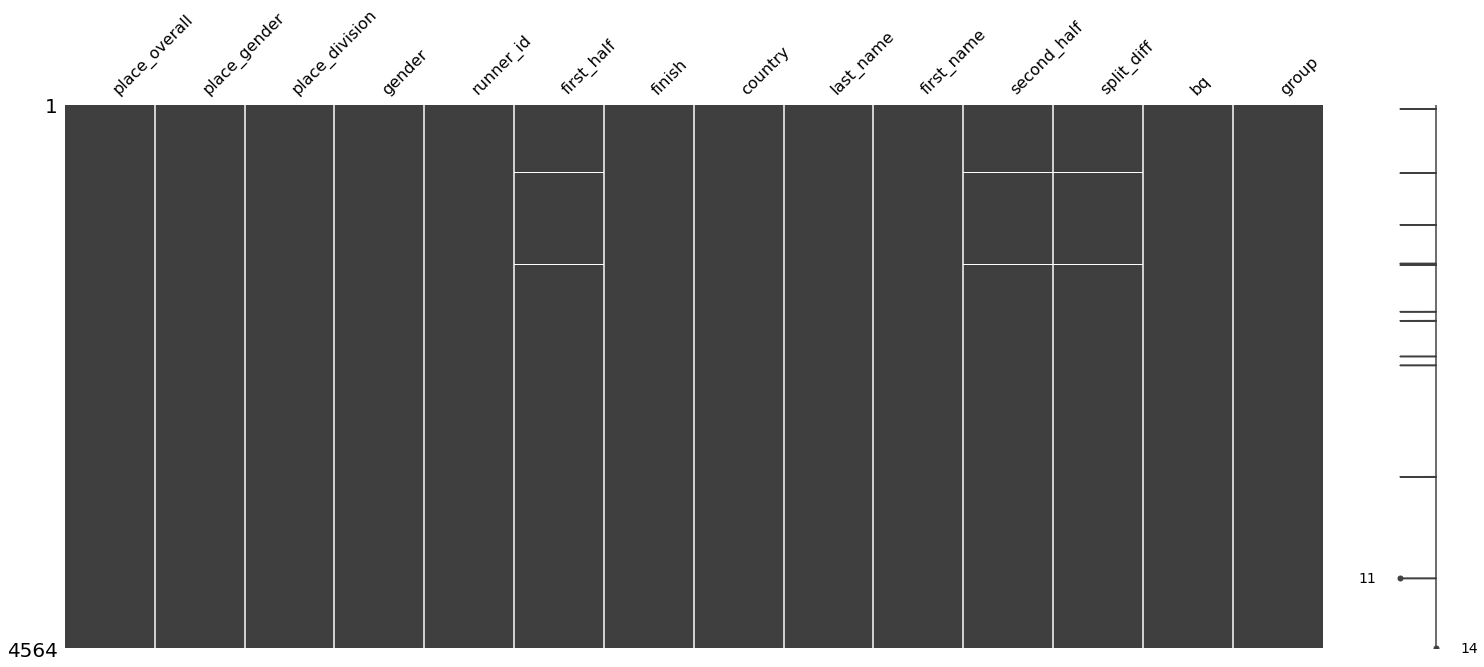

In [27]:
sorted_boston = boston.sort_values(by='finish')
msno.matrix(sorted_boston)
plt.show()

The missing values don't appear to follow any pattern. Since we don't have many clues about why these times might be missing, one way we might be able to get more information is to create a dummy variable that is 1 if the half split is missing, then perform a logistic regression of this dummy variable on other variables in the data. Any large, statistically significant coefficients in the results might indicate that there is a pattern to the missing data [4]. We will perform a regression of this dummy variable on finish time and gender. As we noted earlier, these might be correlated, so this won't be a perfect test, but it could give us some clues. While we are doing this, let's also map the values of the gender column to a dummy variable, with 1 representing men and 0 representing women.

In [28]:
#Create a dummy variable that is 1 when half split is missing
boston['missing_half'] = 0
boston.loc[boston['first_half'].isna(), 'missing_half'] = 1

#Map gender column from M/F to 1/0
boston['gender'] = boston['gender'].map({'M':1, 'W':0})

#Perform logistic regression of dummy variable on other numeric variables
missing_half_logit = smf.logit('missing_half ~ finish + gender', data=boston)
missing_half_logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.016518
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           missing_half   No. Observations:                 4564
Model:                          Logit   Df Residuals:                     4561
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Jun 2022   Pseudo R-squ.:                 0.02470
Time:                        12:20:05   Log-Likelihood:                -75.386
converged:                       True   LL-Null:                       -77.295
Covariance Type:            nonrobust   LLR p-value:                    0.1482
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7514      2.390     -0.733      0.464      -6.436       2.933
finish        -1.1585      0.688     -1.684      0.092      -2.507       0.190
gender        -0.9022      0.708     -1.274      0.203      -2.290       0.486
==============================================================================
"""

The results suggest that missing half splits might be related to finish time, but this pattern doesn't appear to be very strong, being barely statistically significant at the 10% level. Given the small number of missing values, the lack of discernible patterns in the missingness, and the fact that we can't use these rows to analyze pace strategy anyway, we will assume the missingness is random and drop the rows with missing values.

In [29]:
boston.dropna(subset=['first_half'], inplace=True)

Let's also drop the missing_half column because we will no longer need it.

In [30]:
boston.drop(['missing_half'], axis=1, inplace=True)

## VIII. Conclusion

Let's look at the finished DataFrame.

In [31]:
boston

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name,second_half,split_diff,bq,group
1,1,1,1,1,4,1.11,2.16,Kenya,Kipruto,Benson,1.06,-2.22,1,bq_men
2,2,2,2,1,3,1.11,2.18,Ethiopia,Berhanu,Lemi,1.07,-1.65,1,bq_men
3,3,3,3,1,21,1.11,2.18,Ethiopia,Yimer,Jemal,1.07,-1.58,1,bq_men
4,4,4,4,1,12,1.11,2.18,Ethiopia,Ayana,Tsedat,1.07,-1.49,1,bq_men
5,5,5,5,1,22,1.11,2.19,Kenya,Barsoton,Leonard,1.08,-1.18,1,bq_men
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11888,13829,6549,2495,0,16170,2.39,5.00,United States,Faulds,Emily,2.61,4.41,0,no_bq_women
11889,13833,6553,2496,0,17156,2.30,5.00,United States,Alexander,Lucia,2.69,7.86,0,no_bq_women
11890,13840,6556,2497,0,18480,2.32,5.00,United States,Maloney,Maeve,2.68,7.13,0,no_bq_women
11891,13846,6559,2498,0,17205,2.37,5.00,United States,Burke,Kelsey,2.63,5.04,0,no_bq_women


Now that we have cleaned the data, let's export it to a .csv file.

In [32]:
boston.to_csv('./data/boston_clean.csv', index=False)

## IX. References

1. March DS, Vanderburgh PM, Titlebaum PJ, Hoops ML. (2011) 'Age, Sex, and Finish Time as Determinants of Pacing in the Marathon'. Journal of Strength and Conditioning Research: February 2011 - Volume 25 - Issue 2 - p 386-391. https://journals.lww.com/nsca-jscr/Fulltext/2011/02000/Age,_Sex,_and_Finish_Time_as_Determinants_of.14.aspx. 
2. Roy B. September 3, 2019, 'All About Missing Data Handling'. Towards Data Science. https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4.
3. Swalin A. January 30, 2018, 'How to Handle Missing Data'. Towards Data Science. https://towardsdatascience.com/all-about-missing-data-handling-b94b8b5d2184.
4. Buisson F (2021). Behavioral Data Analysis with R and Python. O’Reilly Media, Inc.